
<div style="background-color: darkblue; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">Digit Recognizer using NN Stochastic Gradient Descend (SGD)</h2>
    <p style="text-align: left;"><strong>Author:</strong> Pedro Perez Alvarez</p>
    <p style="text-align: left;"><strong>Date:</strong> 2/23/2025</p>
</div>



<div style="background-color: purple; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">Introduction</h2>
    <p style="text-align: left;">
    The objective of this assignment is to prepare and analyze the results of various Neural Networks models using Stochastic Gradient Descent algorythm. The assignment involves tasks such as model comparison, and presenting findings through tables, graphs, and conclusions.  This analysis will utilize the MNIST ("Modified National Institute of Standards and Technology") dataset, a widely recognized benchmark in computer vision for handwritten digit recognition. The dataset, comprising thousands of handwritten images, offers an excellent platform to experiment with various models and compare their performance.
    </p>
</div>


<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">II. Libraries load / Data load</h4>
    <p style="text-align: left;">
    </p>
</div>


In [1]:
import sys
print(sys.version)


3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [6]:
%pip install --upgrade pip
%pip install scikeras
# %pip install tensorflow==2.19.0



In [4]:
import os
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'
os.environ['KAGGLE_KEY']      = 'you_kaggle_key'

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [7]:
# Step 0: Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import tensorflow as tf
import time
import warnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Input

# Import SciKeras's KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

import zipfile

warnings.filterwarnings("ignore", category=FutureWarning)

api = KaggleApi()
api.authenticate()

api.competition_download_files('digit-recognizer', path='.', force=True, quiet=False)

with zipfile.ZipFile('digit-recognizer.zip', 'r') as z:
    z.extractall('.')


import pandas as pd
train_data = pd.read_csv('train.csv')
test_data  = pd.read_csv('test.csv')



100%|██████████| 15.3M/15.3M [00:00<00:00, 698MB/s]

<div style="background-color: purple; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">Data Presentation</h2>
    <p style="text-align: left;">
        <a href="https://www.kaggle.com/c/digit-recognizer/data" target="_blank" style="color: white; text-decoration: underline;">
        Per Digit Recognizer in the Kaggle Site
        </a>
        ,the data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.  The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero). The train and test datasets have 42,000 and 28,000 observations,respectively.
    </p>
</div>


In [8]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [ ]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_data.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_data.shape


(42000, 785)

In [ ]:
test_data.shape

(28000, 784)

<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">EDA of Initial Dataset</h4>
    <p style="text-align: left;"></p>
</div>

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object


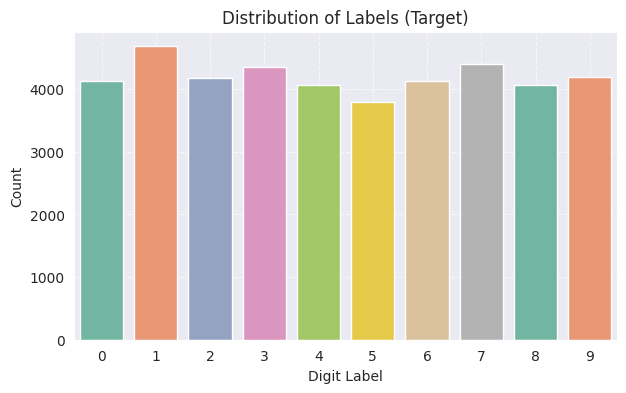

Missing Data Summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage (%)]
Index: []
No missing data found in the dataset.
Total Duplicate Records: 0
Pixel Columns Data Type: [dtype('int32')]
Label Column Data Type: int64

Pixel Intensity Variance Outliers:
       label  pixel_variance                    Outlier_Type
15         1     2124.919254   Low Variance (Possibly Blank)
77         1     2070.743645   Low Variance (Possibly Blank)
371        1     1836.076935   Low Variance (Possibly Blank)
529        1     1717.986862   Low Variance (Possibly Blank)
578        7     2099.742277   Low Variance (Possibly Blank)
...      ...             ...                             ...
41402      0    11685.968630  High Variance (Possibly Noise)
41406      8    10976.718423  High Variance (Possibly Noise)
41508      0    11189.465420  High Variance (Possibly Noise)
41626      0    11468.192972  High Variance (Possibly Noise)
41636      0    11209.201500  High Variance (Possibly Noise

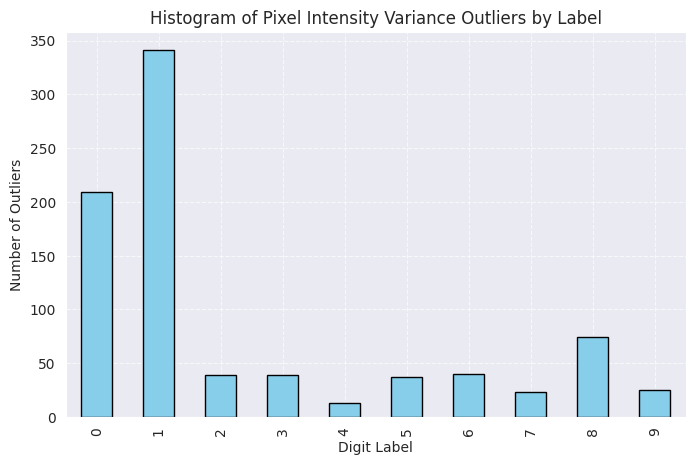

Total number of outliers identified: 840


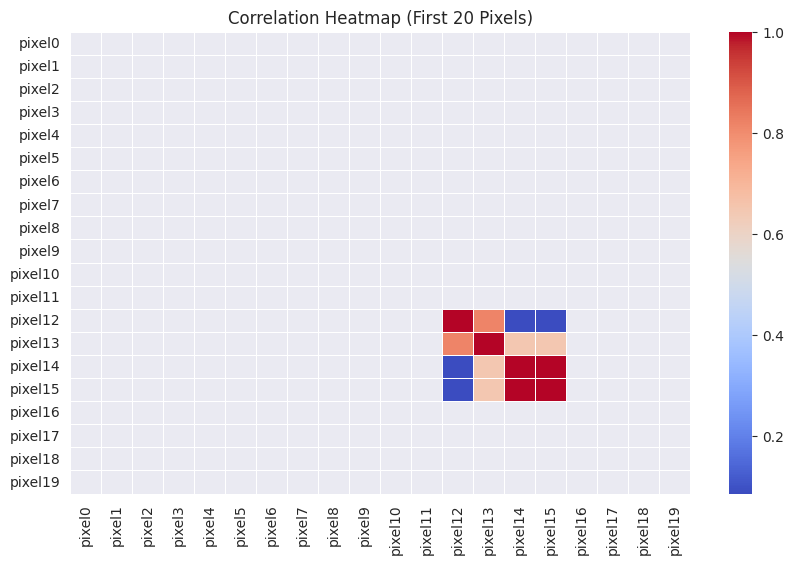

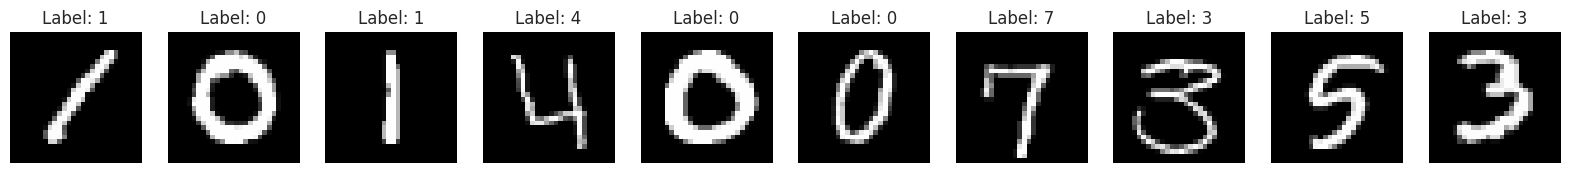

In [ ]:
### THIS SESSION INVESTIGATES TRAIN DATA ###

print(train_data.dtypes)

## Distribution of Label (Y-Response)  ##

plt.figure(figsize=(7, 4))
sns.countplot(x='label', data=train_data, palette='Set2', legend=False)
plt.title("Distribution of Labels (Target)")
plt.xlabel("Digit Label")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Calculate missing values for each column ##

missing_data = train_data.isnull().sum()
missing_percentage = (missing_data / len(train_data)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values
print("Missing Data Summary:")
print(missing_summary)

# Check if there are missing values to visualize
if not missing_summary.empty:
    # Visualize missing data using a bar chart
    plt.figure(figsize=(12, 6))
    missing_summary['Missing Count'].plot(kind='bar', color='skyblue')
    plt.title("Bar Chart of Missing Data by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Missing Count", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing data found in the dataset.")

# Check for values less than 0
less_than_zero = (train_data < 0).sum()
less_than_zero = less_than_zero[less_than_zero > 0]

# Check for values greater than 255
greater_than_255 = (train_data > 255).sum()
greater_than_255 = greater_than_255[greater_than_255 > 0]

# Check for duplicates
duplicate_count = train_data.duplicated().sum()
print(f"Total Duplicate Records: {duplicate_count}")

# Ensure pixel columns are integers
pixel_columns = [col for col in train_data.columns if col != 'label']

# Convert pixels to integer (if not already)
train_data[pixel_columns] = train_data[pixel_columns].astype(np.int32)

# Verify data types
pixel_dtype_check = train_data[pixel_columns].dtypes.unique()
label_dtype_check = train_data['label'].dtype

print(f"Pixel Columns Data Type: {pixel_dtype_check}")
print(f"Label Column Data Type: {label_dtype_check}")

### Investigate Outliers by checking Pixel Intensity  ###

# Identify pixel columns (excluding label)
pixel_columns = [col for col in train_data.columns if col != 'label']

train_data = train_data.copy()

# Calculate pixel intensity variance for each image
train_data['pixel_variance'] = train_data[pixel_columns].var(axis=1)

# Identify images with extremely low or high variance (Potential Outliers)
low_variance_threshold = train_data['pixel_variance'].quantile(0.01)  # Bottom 1%
high_variance_threshold = train_data['pixel_variance'].quantile(0.99)  # Top 1%

low_variance_outliers = train_data[train_data['pixel_variance'] < low_variance_threshold]
high_variance_outliers = train_data[train_data['pixel_variance'] > high_variance_threshold]

# Combine results
variance_outliers = pd.concat([
    low_variance_outliers.assign(Outlier_Type='Low Variance (Possibly Blank)'),
    high_variance_outliers.assign(Outlier_Type='High Variance (Possibly Noise)')
])

# Display results directly
print("\nPixel Intensity Variance Outliers:")
print(variance_outliers[['label', 'pixel_variance', 'Outlier_Type']])

# Save results to CSV
output_path = r'C:\Users\pgper\PyCharmMiscProject\pixel_intensity_variance_outliers.csv'
variance_outliers.to_csv(output_path, index=False)
print(f"\nOutlier details saved to '{output_path}'")

# Create a histogram of outliers by label
plt.figure(figsize=(8, 5))
variance_outliers['label'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Histogram of Pixel Intensity Variance Outliers by Label')
plt.xlabel('Digit Label')
plt.ylabel('Number of Outliers')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Show total number of outliers identified
total_outliers = len(variance_outliers)
print(f"Total number of outliers identified: {total_outliers}")

# Check pixel value distribution
pixel_columns = [col for col in train_data.columns if 'pixel' in col]

corr_matrix = train_data[pixel_columns[:20]].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Correlation Heatmap (First 20 Pixels)")
plt.show()

# Display Sample Images (First 10)
plt.figure(figsize=(20, 16))
for i in range(10):
    pixels = np.array(train_data.iloc[i, 1:].values, dtype=np.float32)[:784]
    image = pixels.reshape(28, 28)
    plt.subplot(1, 10, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {train_data.iloc[i, 0]}")
    plt.axis('off')
plt.show()



In [ ]:
### THIS SESSION INVESTIGATES TEST DATA ###

# MISSING VALUES CHECK #

# Calculate missing values for each column
missing_data = test_data.isnull().sum()
missing_percentage = (missing_data / len(test_data)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values

print("Missing Data Summary:")
print(missing_summary)

# Visualize missing data if any
if not missing_summary.empty:
    plt.figure(figsize=(12, 6))
    missing_summary['Missing Count'].plot(kind='bar', color='skyblue')
    plt.title("Bar Chart of Missing Data by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Missing Count", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing data found in the dataset.")

# DATA VALIDATION CHECKS #

# Check for values less than 0
less_than_zero = (test_data < 0).sum()
less_than_zero = less_than_zero[less_than_zero > 0]

# Check for values greater than 255
greater_than_255 = (test_data > 255).sum()
greater_than_255 = greater_than_255[greater_than_255 > 0]

# Check for duplicates
duplicate_count = test_data.duplicated().sum()
print(f"Total Duplicate Records: {duplicate_count}")

# DATA TYPE VALIDATION #

# Ensure pixel columns are integers and labels are categorical
pixel_columns = [col for col in test_data.columns if col != 'label']

# Convert pixels to integer (if not already)
test_data[pixel_columns] = test_data[pixel_columns].astype(np.int32)

# Verify data types
pixel_dtype_check = test_data[pixel_columns].dtypes.unique()
print(f"Pixel Columns Data Type: {pixel_dtype_check}")

# Identify pixel columns (excluding label)
pixel_columns = [col for col in test_data.columns if col != 'label']

test_data = test_data.copy()

# Calculate pixel intensity variance for each image
test_data['pixel_variance'] = test_data[pixel_columns].var(axis=1)

# Identify images with extremely low or high variance (Potential Outliers)
low_variance_threshold = test_data['pixel_variance'].quantile(0.01)  # Bottom 1%
high_variance_threshold = test_data['pixel_variance'].quantile(0.99)  # Top 1%

low_variance_outliers = test_data[test_data['pixel_variance'] < low_variance_threshold]
high_variance_outliers = test_data[test_data['pixel_variance'] > high_variance_threshold]

# Combine results
variance_outliers = pd.concat([
    low_variance_outliers.assign(Outlier_Type='Low Variance (Possibly Blank)'),
    high_variance_outliers.assign(Outlier_Type='High Variance (Possibly Noise)')
])

# VALUE RANGE VALIDATION #

if not less_than_zero.empty:
    print("\nColumns with values less than 0:")
    print(less_than_zero)
else:
    print("\nNo values less than 0 found.")

if not greater_than_255.empty:
    print("\nColumns with values greater than 255:")
    print(greater_than_255)
else:
    print("\nNo values greater than 255 found.")


Missing Data Summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage (%)]
Index: []
No missing data found in the dataset.
Total Duplicate Records: 0
Pixel Columns Data Type: [dtype('int32')]

No values less than 0 found.

No values greater than 255 found.


<div style="background-color: purple; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">Overview of Findings and Next Steps</h2>
    <p style="text-align: left;">
    </p>
</div>


<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">Cleansing and Preprocessing</h4>
    <p style="text-align: left;">
    </p>
</div>


In [ ]:
## Identify corrupt images ##

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

# Identify corrupt images (uniform pixel values)
logging.info("Checking for corrupt images...")
uniform_images = train_data.iloc[:, 1:].apply(lambda x: x.nunique() == 1, axis=1)
corrupt_images = train_data[uniform_images]

# Display count of corrupt images
corrupt_count = len(corrupt_images)
logging.info(f"Number of corrupt images: {corrupt_count}")

# Visualize a few corrupt images
if corrupt_count > 0:
    logging.info("Displaying sample corrupt images...")
    plt.figure(figsize=(10, 5))
    for i, (_, row) in enumerate(corrupt_images.head(5).iterrows()):
        image = np.array(row.iloc[1:].values, dtype=np.float32).reshape(28, 28)
        plt.subplot(1, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.suptitle('Sample Corrupt Images (Uniform Pixels)')
    plt.show()
else:
    logging.info("No corrupt images found.")



Checking for corrupt images...
Number of corrupt images: 0
No corrupt images found.


In [ ]:
# train_data.describe()

<div style="background-color: purple; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">Overview of Preprocessing</h2>
    <p style="text-align: left;">
    </p>
</div>

<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;"> Data Preprocessing Specific to the Neural Networks</h4>
    <p style="text-align: left;">
    </p>
</div>

In [ ]:
train_data = train_data.dropna(subset=["label"])

<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">Splitting</h4>
    <p style="text-align: left;"></p>
</div>

In [ ]:
X = train_data.drop(columns=["label"]).values
y_raw = train_data["label"].values
num_classes = len(np.unique(y_raw))

<div style="background-color: white; padding: 15px; border-radius: 5px;color: black;">
    <h4 style="text-align: left;">Feature Engineering</h4>
    <p style="text-align: left;">
    </p>
</div>

In [ ]:
# Scale to [0..1], assuming pixel values are 0..255
X = X / 255.0

# One-hot encode
y = tf.keras.utils.to_categorical(y_raw, num_classes=num_classes)

<div style="background-color: purple; padding: 15px; border-radius: 5px;">
    <h2 style="text-align: left;">Neural NetWork Modeling (i.e. model creation, model training, model evaluation) </h2>
    <p style="text-align: left;">
    </p>
</div>

<div style="background-color: lightblue; padding: 15px; border-radius: 5px;color: black;">
    <h3 style="text-align: left;">Model 1 - NN Stochastic Gradient Descend (SGD) with 2 Layers and 10 Nodes</h3>
    <p style="text-align: left;">
    </p>
</div>

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Manual K-Fold Accuracies: [0.87904762 0.88059524 0.86583333 0.87892857 0.87321429]
Mean Accuracy: 0.8755 ± 0.0055
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


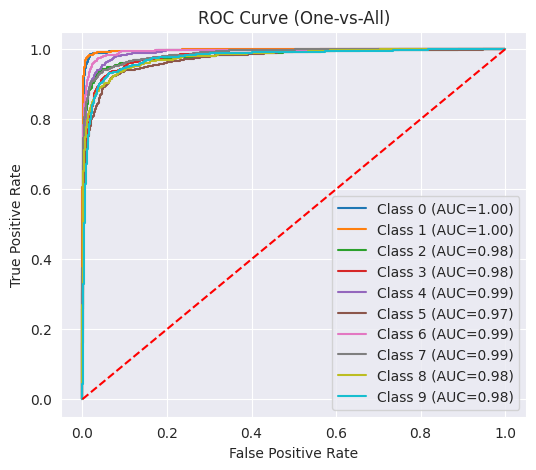

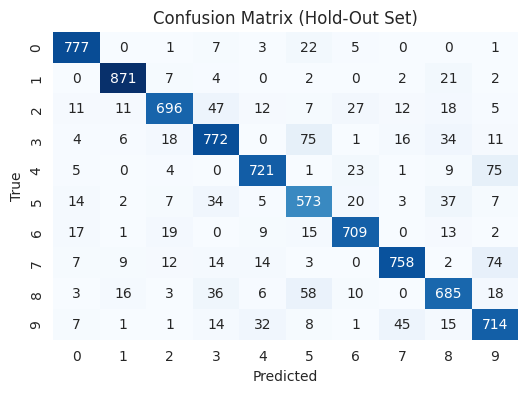

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Submission saved to 'nn_sgd_submission.csv'


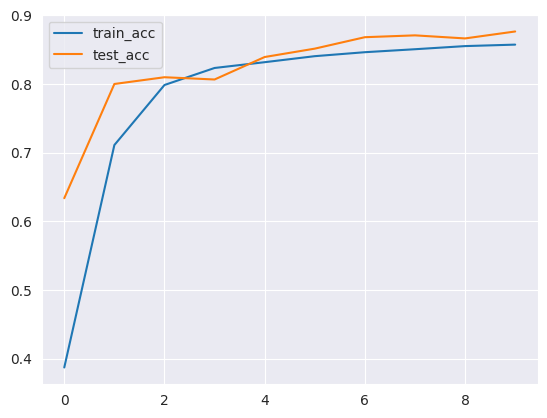

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       816
           1       0.95      0.96      0.95       909
           2       0.91      0.82      0.86       846
           3       0.83      0.82      0.83       937
           4       0.90      0.86      0.88       839
           5       0.75      0.82      0.78       702
           6       0.89      0.90      0.90       785
           7       0.91      0.85      0.88       893
           8       0.82      0.82      0.82       835
           9       0.79      0.85      0.82       838

    accuracy                           0.87      8400
   macro avg       0.87      0.87      0.87      8400
weighted avg       0.87      0.87      0.87      8400

SGD 2L 10N Processing Time: 130.28 seconds


In [ ]:
# ## Model 1- Stochastic Gradient Descend 2 Layers and 10 Nodes##
#
#############################################################
# Split Data into Train & Test Sets
#############################################################
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42
)
#############################################################
# Define a Model-Building Function
#############################################################
start_time = time.time()


def create_model():
    """
    Build a 2-layer NN (1 hidden layer w/ 10 nodes, ReLU) using SGD.
    """
    model = Sequential()
    # Step 2: Use a dedicated Input layer
    model.add(Input(shape=(X.shape[1],)))

    # Hidden layer: 10 units, ReLU
    model.add(Dense(units=10, activation='relu'))

    # Output layer: 'num_classes' units, softmax
    model.add(Dense(units=num_classes, activation='softmax'))

    # Stochastic Gradient Descent
    optimizer = SGD(learning_rate=0.01)  # Tune if needed
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

#############################################################
#  Manual K-Fold Cross Validation on Entire TRAIN Data
#############################################################
fold_accuracies = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Create and train a new model for this fold
    model_fold = create_model()
    model_fold.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model on the validation fold
    predictions_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(predictions_fold, axis=1)
    y_true_fold = np.argmax(y_val_fold, axis=1)

    # Calculate accuracy and save it
    acc = accuracy_score(y_true_fold, y_pred_fold)
    fold_accuracies.append(acc)

fold_accuracies = np.array(fold_accuracies)

print("\nManual K-Fold Accuracies:", fold_accuracies)
print(f"Mean Accuracy: {fold_accuracies.mean():.4f} ± {fold_accuracies.std():.4f}")
#
#############################################################
# Build a Fresh Model and Train on the (X_train, y_train)
#############################################################

model = create_model()

history = model.fit(
    X_train, y_train,
    epochs=10,        # Tune as needed
    batch_size=32,    # Tune as needed
    validation_split=0.1,
    verbose=0
)


#############################################################
# Evaluate on the Hold-Out Set (test)
#############################################################

predictions = model.predict(X_holdout)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_holdout, axis=1)

# Assign predictions to y_proba_holdout for ROC curve plotting
y_proba_holdout = predictions

def plot_multiclass_roc(y_true, y_proba, num_classes):
    """
    Plot one-vs-all ROC curves for a multi-class problem.
    y_true, y_proba are shape (samples, num_classes).
    """
    plt.figure(figsize=(6, 5))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC Curve (One-vs-All)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC Curve
plot_multiclass_roc(y_holdout, y_proba_holdout, num_classes)

def plot_confusion_mat(actual, predicted):
    """
    Plot a confusion matrix using seaborn heatmap.
    actual, predicted are 1D arrays of class indices.
    """
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix (Hold-Out Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Plot Confusion Matrix
plot_confusion_mat(actual_classes, predicted_classes)

# # Print the shape of the confusion matrix and force immediate output
# print("Confusion Matrix shape:", conf_matrix.shape, flush=True)
# print("Confusion Matrix (Hold-Out Set):", flush=True)
# display(conf_matrix)

#############################################################
# Predict Using the TEST Data & Prepare Submission
#############################################################
# Scale TEST data the same way (assuming test_data has no 'label' column)
test_data_scaled = test_data / 255.0

# Predict probabilities, then take argmax for final labels
test_predictions = model.predict(test_data_scaled)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Store predictions in a DataFrame
test_results = pd.DataFrame({"Label": test_predicted_labels})

# Create test_data_id based on the length of test_results
test_data_id = pd.DataFrame({"ImageId": range(1, len(test_predicted_labels) + 1)})

# Prepare final submission file
final_submission = pd.DataFrame({
    "ImageId": test_data_id["ImageId"],
    "Label": test_results["Label"]
})

# Save to CSV (the file will be saved in the current working directory)
final_submission.to_csv("nn_sgd_submission.csv", index=False)
print("\nSubmission saved to 'nn_sgd_submission.csv'")

# (Optional) Visualize Training Progress
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.legend()
plt.show()

print(classification_report(actual_classes, predicted_classes))

end_time = time.time()
print(f"SGD 2L 10N Processing Time: {end_time - start_time:.2f} seconds")


<div style="background-color: lightblue; padding: 15px; border-radius: 5px;color: black;">
    <h3 style="text-align: left;">Mode2- NN Stochastic Gradient Descend (SGD) with 2 Layers,20 Nodes, 12 Epochs  </h3>
    <p style="text-align: left;">
    </p>
</div>

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Manual K-Fold Accuracies: [0.9072619  0.90452381 0.90488095 0.91619048 0.90297619]
K-Fold CV: Mean Accuracy: 0.9072 ± 0.0047
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


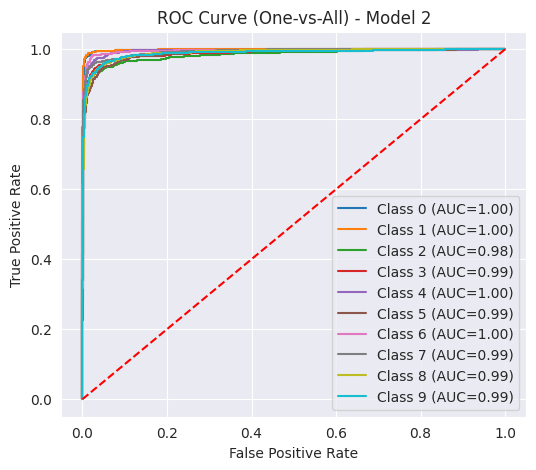

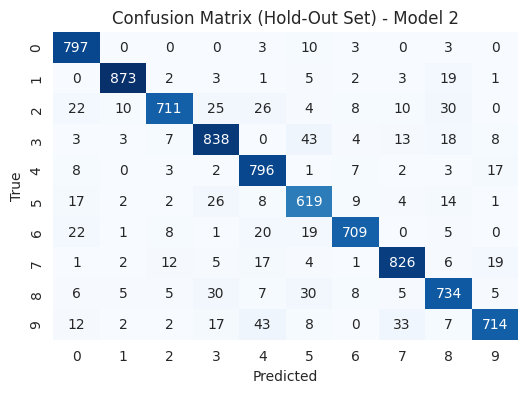

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Submission saved to 'nn_sgd_submission.csv'


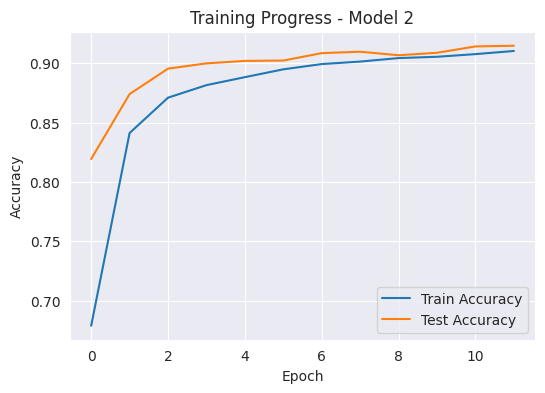

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       816
           1       0.97      0.96      0.97       909
           2       0.95      0.84      0.89       846
           3       0.88      0.89      0.89       937
           4       0.86      0.95      0.90       839
           5       0.83      0.88      0.86       702
           6       0.94      0.90      0.92       785
           7       0.92      0.92      0.92       893
           8       0.87      0.88      0.88       835
           9       0.93      0.85      0.89       838

    accuracy                           0.91      8400
   macro avg       0.91      0.91      0.91      8400
weighted avg       0.91      0.91      0.91      8400

SGD 2L 20N 12E Processing Time: 153.91 seconds


In [ ]:
#############################################################
# Model 2 - Stochastic Gradient Descend 2 Layers, 20 Nodes, 12 Epochs


#############################################################
# Split Data into Train & Test Sets
#############################################################
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#############################################################
# Define a Model-Building Function for Model 2
#############################################################
start_time = time.time()

def create_model():
    """
    Build a 2-layer NN (1 hidden layer w/ 20 nodes, ReLU) using SGD.
    """
    model = Sequential()
    # Use a dedicated Input layer
    model.add(Input(shape=(X.shape[1],)))

    # Hidden layer: 20 units, ReLU
    model.add(Dense(units=20, activation='relu'))

    # Output layer: 'num_classes' units, softmax
    model.add(Dense(units=num_classes, activation='softmax'))

    # Stochastic Gradient Descent
    optimizer = SGD(learning_rate=0.01)  # Tune if needed
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

#############################################################
# Manual K-Fold Cross Validation on Entire TRAIN Data
#############################################################
fold_accuracies = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Create and train a new model for this fold using 12 epochs
    model_fold = create_model()
    model_fold.fit(X_train_fold, y_train_fold, epochs=12, batch_size=32, verbose=0)

    # Evaluate the model on the validation fold
    predictions_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(predictions_fold, axis=1)
    y_true_fold = np.argmax(y_val_fold, axis=1)

    # Calculate accuracy and save it
    acc = accuracy_score(y_true_fold, y_pred_fold)
    fold_accuracies.append(acc)

fold_accuracies = np.array(fold_accuracies)
cv_mean = fold_accuracies.mean()
cv_std = fold_accuracies.std()
print("\nManual K-Fold Accuracies:", fold_accuracies)
print(f"K-Fold CV: Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")

#############################################################
# Build a Fresh Model and Train on the (X_train, y_train)
#############################################################
model = create_model()

history = model.fit(
    X_train, y_train,
    epochs=12,        # 12 epochs
    batch_size=32,    # Tune if needed
    validation_split=0.1,
    verbose=0
)

#############################################################
# Evaluate on the Hold-Out Set (test)
#############################################################
predictions = model.predict(X_holdout)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_holdout, axis=1)

# For ROC curve plotting, assign predictions to y_proba_holdout
y_proba_holdout = predictions

def plot_multiclass_roc(y_true, y_proba, num_classes):
    """
    Plot one-vs-all ROC curves for a multi-class problem.
    y_true, y_proba are shape (samples, num_classes).
    """
    plt.figure(figsize=(6, 5))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC Curve (One-vs-All) - Model 2')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC Curve
plot_multiclass_roc(y_holdout, y_proba_holdout, num_classes)

def plot_confusion_mat(actual, predicted):
    """
    Plot a confusion matrix using seaborn heatmap.
    actual, predicted are 1D arrays of class indices.
    """
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix (Hold-Out Set) - Model 2")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Plot Confusion Matrix
plot_confusion_mat(actual_classes, predicted_classes)

#############################################################
# Predict Using the TEST Data & Prepare Submission
#############################################################
# Scale TEST data the same way (assuming test_data has no 'label' column)
test_data_scaled = test_data / 255.0

# Predict probabilities, then take argmax for final labels
test_predictions = model.predict(test_data_scaled)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Store predictions in a DataFrame
test_results = pd.DataFrame({"Label": test_predicted_labels})

# Create test_data_id based on the length of test_results
test_data_id = pd.DataFrame({"ImageId": range(1, len(test_predicted_labels) + 1)})

# Prepare final submission file
final_submission = pd.DataFrame({
    "ImageId": test_data_id["ImageId"],
    "Label": test_results["Label"]
})

# Save to CSV (the file will be saved in the current working directory)
final_submission.to_csv("nn_sgd_submission.csv", index=False)
print("\nSubmission saved to 'nn_sgd_submission.csv'")

# (Optional) Visualize Training Progress
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training Progress - Model 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(classification_report(actual_classes, predicted_classes))

end_time = time.time()
print(f"SGD 2L 20N 12E Processing Time: {end_time - start_time:.2f} seconds")


<div style="background-color: lightblue; padding: 15px; border-radius: 5px;color: black;">
    <h3 style="text-align: left;">Model 3 - NN Stochastic Gradient Descend (SGD) with 5 Layers and 20 Nodes, 20 Epochs</h3>
    <p style="text-align: left;">
    </p>
</div>

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Manual K-Fold Accuracies: [0.9272619  0.91761905 0.91880952 0.9272619  0.93035714]
K-Fold CV: Mean Accuracy: 0.9243 ± 0.0051
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


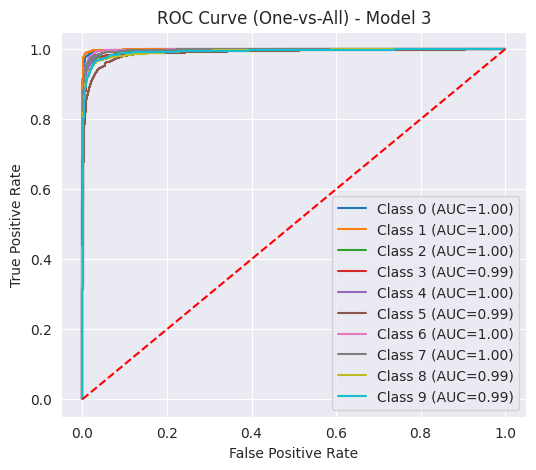

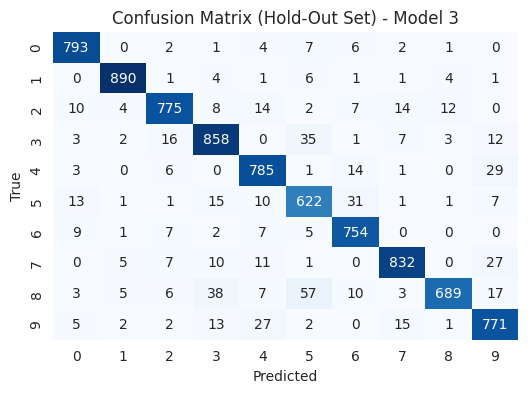

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Submission saved to 'nn_sgd_submission.csv'


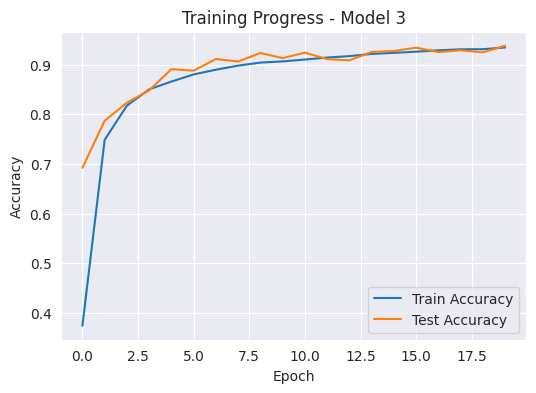

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       816
           1       0.98      0.98      0.98       909
           2       0.94      0.92      0.93       846
           3       0.90      0.92      0.91       937
           4       0.91      0.94      0.92       839
           5       0.84      0.89      0.86       702
           6       0.92      0.96      0.94       785
           7       0.95      0.93      0.94       893
           8       0.97      0.83      0.89       835
           9       0.89      0.92      0.91       838

    accuracy                           0.92      8400
   macro avg       0.92      0.92      0.92      8400
weighted avg       0.93      0.92      0.92      8400

SGD 5L 20N 20E Processing Time: 277.88 seconds


In [ ]:
# Model 3 - Stochastic Gradient Descend 5 Layers (4 Hidden, 1 Output),
# 20 Nodes per Hidden Layer, 20 Epochs

#############################################################
# Split Data into Train & Test Sets
#############################################################
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#############################################################
# Define a Model-Building Function for Model 3
#############################################################
start_time = time.time()

def create_model():
    """
    Build a 5-layer NN:
      - 4 hidden layers with 20 nodes each (ReLU),
      - 1 output layer with 'num_classes' nodes (softmax),
      - Uses SGD with a learning rate of 0.01.
    """
    model = Sequential()
    # Use a dedicated Input layer
    model.add(Input(shape=(X.shape[1],)))

    # 4 Hidden layers: each with 20 units and ReLU activation
    for _ in range(4):
        model.add(Dense(units=20, activation='relu'))

    # Output layer: 'num_classes' units, softmax activation
    model.add(Dense(units=num_classes, activation='softmax'))

    optimizer = SGD(learning_rate=0.01)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

#############################################################
#  Manual K-Fold Cross Validation on Entire TRAIN Data
#############################################################
fold_accuracies = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Create and train a new model for this fold with 20 epochs
    model_fold = create_model()
    model_fold.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, verbose=0)

    # Evaluate the model on the validation fold
    predictions_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(predictions_fold, axis=1)
    y_true_fold = np.argmax(y_val_fold, axis=1)

    # Calculate accuracy and save it
    acc = accuracy_score(y_true_fold, y_pred_fold)
    fold_accuracies.append(acc)

fold_accuracies = np.array(fold_accuracies)
cv_mean = fold_accuracies.mean()
cv_std = fold_accuracies.std()
print("\nManual K-Fold Accuracies:", fold_accuracies)
print(f"K-Fold CV: Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")

#############################################################
# Build a Fresh Model and Train on the (X_train, y_train)
#############################################################
model = create_model()

history = model.fit(
    X_train, y_train,
    epochs=20,        # 20 epochs
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

#############################################################
# Evaluate on the Hold-Out Set (test)
#############################################################
predictions = model.predict(X_holdout)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_holdout, axis=1)

# Assign predictions to y_proba_holdout for ROC curve plotting
y_proba_holdout = predictions

def plot_multiclass_roc(y_true, y_proba, num_classes):
    """
    Plot one-vs-all ROC curves for a multi-class problem.
    y_true, y_proba are shape (samples, num_classes).
    """
    plt.figure(figsize=(6, 5))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC Curve (One-vs-All) - Model 3')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC Curve
plot_multiclass_roc(y_holdout, y_proba_holdout, num_classes)

def plot_confusion_mat(actual, predicted):
    """
    Plot a confusion matrix using seaborn heatmap.
    actual, predicted are 1D arrays of class indices.
    """
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix (Hold-Out Set) - Model 3")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Plot Confusion Matrix
plot_confusion_mat(actual_classes, predicted_classes)

#############################################################
# Predict Using the TEST Data & Prepare Submission
#############################################################
# Scale TEST data the same way (assuming test_data has no 'label' column)
test_data_scaled = test_data / 255.0

# Predict probabilities, then take argmax for final labels
test_predictions = model.predict(test_data_scaled)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Store predictions in a DataFrame
test_results = pd.DataFrame({"Label": test_predicted_labels})

# Create test_data_id based on the length of test_results
test_data_id = pd.DataFrame({"ImageId": range(1, len(test_predicted_labels) + 1)})

# Prepare final submission file
final_submission = pd.DataFrame({
    "ImageId": test_data_id["ImageId"],
    "Label": test_results["Label"]
})

# Save to CSV (the file will be saved in the current working directory)
final_submission.to_csv("nn_sgd_submission.csv", index=False)
print("\nSubmission saved to 'nn_sgd_submission.csv'")

# (Optional) Visualize Training Progress
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training Progress - Model 3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(classification_report(actual_classes, predicted_classes))

end_time = time.time()
print(f"SGD 5L 20N 20E Processing Time: {end_time - start_time:.2f} seconds")


<div style="background-color: lightblue; padding: 15px; border-radius: 5px;color: black;">
    <h3 style="text-align: left;">Model 4 - NN Stochastic Gradient Descend (SGD) with 10 Layers, 50 Nodes and 25 Epochs</h3>
    <p style="text-align: left;">
    </p>
</div>

2025-02-23 19:40:22.418569: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_324', 72 bytes spill stores, 72 bytes spill loads



263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Manual K-Fold Accuracies: [0.94797619 0.94785714 0.9547619  0.9502381  0.96178571]
K-Fold CV: Mean Accuracy: 0.9525 ± 0.0053
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


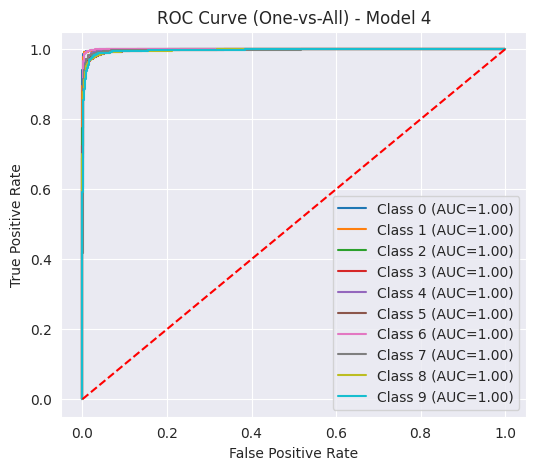

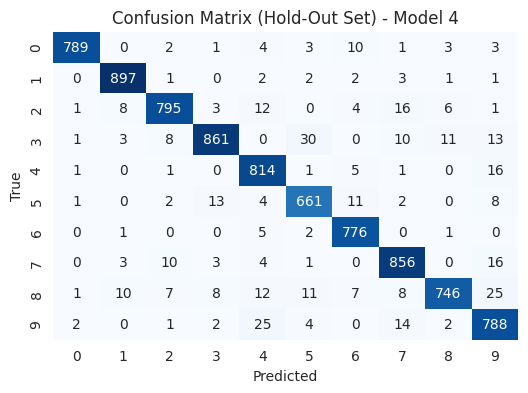

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Submission saved to 'nn_sgd_submission.csv'


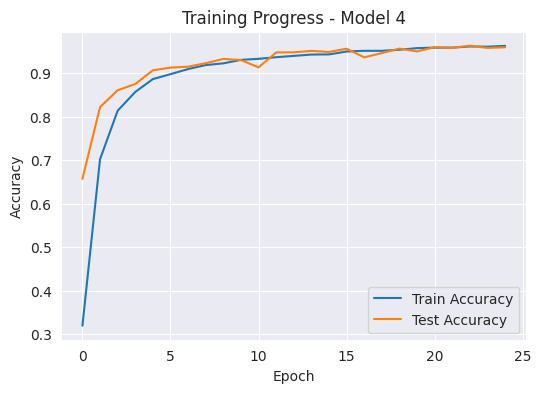

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       816
           1       0.97      0.99      0.98       909
           2       0.96      0.94      0.95       846
           3       0.97      0.92      0.94       937
           4       0.92      0.97      0.95       839
           5       0.92      0.94      0.93       702
           6       0.95      0.99      0.97       785
           7       0.94      0.96      0.95       893
           8       0.97      0.89      0.93       835
           9       0.90      0.94      0.92       838

    accuracy                           0.95      8400
   macro avg       0.95      0.95      0.95      8400
weighted avg       0.95      0.95      0.95      8400

SGD 10L 50N 25E Processing Time: 372.59 seconds


In [ ]:

# Model 4 - Stochastic Gradient Descend 10 Layers (9 Hidden, 1 Output),
# 50 Nodes per Hidden Layer, 25 Epochs



#############################################################
# Split Data into Train & Test Sets
#############################################################
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#############################################################
# Define a Model-Building Function for Model 4
#############################################################
start_time = time.time()

def create_model():
    """
    Build a 10-layer NN:
      - 9 hidden layers with 50 nodes each (ReLU),
      - 1 output layer with 'num_classes' nodes (softmax),
      - Uses SGD with a learning rate of 0.01.
    """
    model = Sequential()
    # Use a dedicated Input layer
    model.add(Input(shape=(X.shape[1],)))

    # 9 Hidden layers: each with 50 units and ReLU activation
    for _ in range(9):
        model.add(Dense(units=50, activation='relu'))

    # Output layer: 'num_classes' units, softmax activation
    model.add(Dense(units=num_classes, activation='softmax'))

    optimizer = SGD(learning_rate=0.01)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

#############################################################
#  Manual K-Fold Cross Validation on Entire TRAIN Data
#############################################################
fold_accuracies = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Create and train a new model for this fold with 25 epochs
    model_fold = create_model()
    model_fold.fit(X_train_fold, y_train_fold, epochs=25, batch_size=32, verbose=0)

    # Evaluate the model on the validation fold
    predictions_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(predictions_fold, axis=1)
    y_true_fold = np.argmax(y_val_fold, axis=1)

    # Calculate accuracy and save it
    acc = accuracy_score(y_true_fold, y_pred_fold)
    fold_accuracies.append(acc)

fold_accuracies = np.array(fold_accuracies)
cv_mean = fold_accuracies.mean()
cv_std = fold_accuracies.std()
print("\nManual K-Fold Accuracies:", fold_accuracies)
print(f"K-Fold CV: Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")

#############################################################
# Build a Fresh Model and Train on the (X_train, y_train)
#############################################################
model = create_model()

history = model.fit(
    X_train, y_train,
    epochs=25,        # 25 epochs
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

#############################################################
# Evaluate on the Hold-Out Set (test)
#############################################################
predictions = model.predict(X_holdout)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_holdout, axis=1)

# Assign predictions to y_proba_holdout for ROC curve plotting
y_proba_holdout = predictions

def plot_multiclass_roc(y_true, y_proba, num_classes):
    """
    Plot one-vs-all ROC curves for a multi-class problem.
    y_true, y_proba are shape (samples, num_classes).
    """
    plt.figure(figsize=(6, 5))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC Curve (One-vs-All) - Model 4')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC Curve
plot_multiclass_roc(y_holdout, y_proba_holdout, num_classes)

def plot_confusion_mat(actual, predicted):
    """
    Plot a confusion matrix using seaborn heatmap.
    actual, predicted are 1D arrays of class indices.
    """
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix (Hold-Out Set) - Model 4")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Plot Confusion Matrix
plot_confusion_mat(actual_classes, predicted_classes)

#############################################################
# Predict Using the TEST Data & Prepare Submission
#############################################################
# Scale TEST data the same way (assuming test_data has no 'label' column)
test_data_scaled = test_data / 255.0

# Predict probabilities, then take argmax for final labels
test_predictions = model.predict(test_data_scaled)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Store predictions in a DataFrame
test_results = pd.DataFrame({"Label": test_predicted_labels})

# Create test_data_id based on the length of test_results
test_data_id = pd.DataFrame({"ImageId": range(1, len(test_predicted_labels) + 1)})

# Prepare final submission file
final_submission = pd.DataFrame({
    "ImageId": test_data_id["ImageId"],
    "Label": test_results["Label"]
})

# Save to CSV (the file will be saved in the current working directory)
final_submission.to_csv("nn_sgd_submission.csv", index=False)
print("\nSubmission saved to 'nn_sgd_submission.csv'")

# (Optional) Visualize Training Progress
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training Progress - Model 4')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(classification_report(actual_classes, predicted_classes))

end_time = time.time()
print(f"SGD 10L 50N 25E Processing Time: {end_time - start_time:.2f} seconds")
